In [1]:
import sys, getopt, re

def main(argv):
    inputfile = ''
    try:
        opts, args = getopt.getopt(argv,"i:")
        # print(opts,args)
    except getopt.GetoptError:
        print('LanguageModeling.py -i <BRAND>')
        sys.exit(2)
    
    for opt, arg in opts:
        if opt == "-i":
            inputfile = arg
    
    if len(inputfile)==0:
        print('usage: LanguageModeling.py -i <BRAND>')
        sys.exit(2)
    print('Input BRAND is ', inputfile)
    return inputfile

In [2]:
BRAND      = 'HAIRCARE'

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

---

In [4]:
from fastai.text import * # Quick access to NLP functionality
from fastai.callbacks import EarlyStoppingCallback, SaveModelCallback

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from numpy import linalg as LA

# Pre-Processing

## Data Loading (from saved verbatim)

In [6]:
df = pd.read_csv('./data/sample_data.csv', dtype={'verbatum':object})

df.head()

,snippet,product,rating,verbatum,sentiment_binary,sentiment,date,retailer,website,topic
0,This shampoo sprays crazy good and it has save...,Head And Shoulders Smooth & Silky Dandruff Sha...,5.0,This shampoo sprays crazy good and it has save...,1,Positive,5/2/2018,-,https://www.walmart.com/ip/Head-and-Shoulders-...,Spray Application
1,The thing I always remember about Head & Shoul...,Head And Shoulders Green Apple Anti-Dandruff S...,5.0,My teenaged daughter has been using Head & Sho...,1,Positive,9/29/2017,AMZ,https://www.amazon.com/Head-Shoulders-Anti-Dan...,Spray Application
2,"My long, thick, wavy, hair is frequently abuse...",Dove Dermacare Scalp Anti-Dandruff Shampoo Inv...,4.0,"To my surprise, Dove DermaCare Scalp Invigorat...",1,Positive,1/27/2017,WALMART,https://www.walmart.com/ip/Dove-Dermacare-Scal...,Spray Application
3,"From their body sprays, to their deodorant, so...",Dove Dermacare Scalp Anti-Dandruff Shampoo Dry...,5.0,I let my boyfriend try this product. He loves ...,1,Positive,1/27/2017,-,https://www.walmart.com/ip/Dove-Dermacare-Scal...,Spray Application
4,"Its conveniently packaged, but if this bottle ...","Head And Shoulders Dry Scalp Care, Almond Oil,...",4.0,"Its conveniently packaged, but if this bottle ...",1,Positive,1/14/2016,AMZ,https://www.amazon.com/Head-Shoulders-Almond-D...,Spray Application


## Data Cleaning

Extract the full verbatum; remove duplicates and too short verbatum 

In [7]:
# keep a copy of the rating
df_orig = df[['rating','product']].copy()

# get full verbatum and enforce
df = df[['verbatum']].rename(columns = {'verbatum':'text'})

# enforce format
df['text'] = df['text'].astype(str)

# remove short comments (keep 2nd percentile and higher lenghts)
thresh = df['text'].apply(len).quantile(0.02)

df = df.loc[df['text'].apply(lambda x: len(x)>=thresh)].\
    drop_duplicates()

In [53]:
df.head()

## Pre-Tokenization

In [9]:
# Setup stop words
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

for word in STOP_WORDS:
    for w in (word, word[0].capitalize(), word.upper()):
        lex = nlp.vocab[w]
        lex.is_stop = True

In [10]:
# from nltk.corpus import stopwords
#import spacy
import string

# stop = set(stopwords.words('english'))
#exclude = set(string.punctuation)-set(['!','?'])

# nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

def preprocess(doc, tags=['NOUN', 'ADJ','VERB','ADV']):
    # make entire text lower case
    doc = doc.lower()    
    
    # replace "n't" with " not" & remove unwanted characters, numbers and symbols
    doc = doc.replace("n\'t", " not").replace("[^a-zA-Z#]", " ")
       
    # remove short words (length < 3)
    # doc = " ".join([r for r in doc.split() if len(r)>2])
    
    # remove punctuation
    # doc = ''.join(ch for ch in doc if ch not in exclude)
    
    # lemmatization
    # doc = " ".join([token.lemma_ for token in nlp(doc) if ((token.pos_ in tags) and not(token.is_stop))])
    return doc

In [11]:
# removes stop words, short words, and punctuation; lowercase and lemmatize all
print(' Pre-Tokenization')
df['text']        = df['text'].apply(preprocess)

 Pre-Tokenization


# Language Modeling

In [12]:
path = './'

path = Path('./')

Train/test split

In [13]:
seq = np.random.rand(len(df)) < .10
df_train = df[ seq]
df_test  = df[~seq]

Parameter for both language and classifier model

In [14]:
moms = (0.8,0.7)

Create a `DataBunch` for each of the language model and the classifier:

In [15]:
data_lm = TextLMDataBunch.from_df(path, train_df=df_train, valid_df=df_test, text_cols='text')

# callbacks
callback_fns = [partial(EarlyStoppingCallback, monitor='accuracy', min_delta=0.01, patience=10),\
                partial(SaveModelCallback, monitor='accuracy', every='improvement', name='lm_{:}.mdl'.format(BRAND))]

# We'll fine-tune the language model. [fast.ai](http://www.fast.ai/) has a 
# pre-trained English model available that we can download, we jsut have to specify it like this:
learner = language_model_learner(data_lm, AWD_LSTM, pretrained=True, \
    callback_fns=callback_fns)

learner.unfreeze()
learner.fit_one_cycle(12, slice(1e-2), moms=moms)

# Save our language model's encoder:
# learner.save_encoder('encoder_{:}'.format(BRAND))

# extract vocab
vocab = data_lm.train_ds.vocab
# with open('./models/vocab_{:}.pkl'.format(BRAND), 'wb') as handle:
#     pickle.dump(vocab, handle, protocol=pickle.HIGHEST_PROTOCOL)

epoch,train_loss,valid_loss,accuracy
1,5.758136,4.763396,0.201890
2,5.187004,3.767621,0.293486
3,4.665152,3.348593,0.322959
4,4.263119,3.177482,0.339610
5,3.959734,3.095756,0.347167
6,3.723692,3.060342,0.351300
7,3.537199,3.028409,0.355470
8,3.379147,3.010930,0.357566
9,3.251802,3.005160,0.358668
10,3.150276,3.001252,0.358994


Better model found at epoch 1 with accuracy value: 0.20189021527767181.
Better model found at epoch 2 with accuracy value: 0.293486088514328.
Better model found at epoch 3 with accuracy value: 0.32295921444892883.
Better model found at epoch 4 with accuracy value: 0.33960995078086853.
Better model found at epoch 5 with accuracy value: 0.3471672832965851.
Better model found at epoch 6 with accuracy value: 0.35130029916763306.
Better model found at epoch 7 with accuracy value: 0.35547035932540894.
Better model found at epoch 8 with accuracy value: 0.3575662076473236.
Better model found at epoch 9 with accuracy value: 0.35866814851760864.
Better model found at epoch 10 with accuracy value: 0.3589940667152405.
Better model found at epoch 11 with accuracy value: 0.3595007658004761.


Save model

In [16]:
if False: learner.export(fname = 'models/languagemodel_{:}.pkl'.format(BRAND.replace(' ','')))

Encode verbatum

In [17]:
learner.predict("the product leave -pron- with itch scalp", n_words=20)

'the product leave -pron- with itch scalp and flaking . the continued effectiveness of this product is the best . xxbos products ! dandruff has been the'

In [47]:
learner.predict("the product leave me with itch scalp", n_words=20)

'the product leave me with itch scalp dryness & itch relief shampoo . i did not have pimples on my scalp ... but i hate this like'

Get encoder matrix in array format

In [18]:
m = learner.model
m.eval()
layers = list(m.children())

emb_mtx = layers[0].encoder.weight.cpu().data.numpy()

Tokenize verbatum

In [19]:
stoi = []
for idx,row in df.iterrows(): 
    posx = list(set(vocab.numericalize(row['text'].split())))
    vct = np.zeros(emb_mtx.shape[0])
    vct[posx]=1
    
    stoi.append(vct)

verbatum_embeddings = np.dot(np.vstack(stoi),emb_mtx)

# normalize
verbatum_embeddings = verbatum_embeddings /LA.norm(verbatum_embeddings, axis=1)[:,np.newaxis]

## Clustering using GMM

In [20]:
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.cluster import KMeans

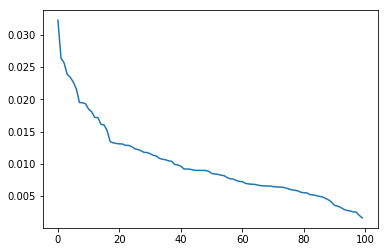

In [153]:
# Variational Bayesian estimation of a Gaussian mixture
dpgmm = BayesianGaussianMixture(n_components=100, covariance_type='full', 
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e0, weight_concentration_prior=1e-3,
    init_params="random", max_iter=100, random_state=2).fit(verbatum_embeddings)

n_components = len(dpgmm.means_)

plt.plot(np.sort(dpgmm.weights_)[::-1])

# best_gmm   = dpgmm
# best_ncomp = len(dpgmm.means_)

In [21]:
lowest_bic = np.infty
bic = []
n_components_range = [15,20,25,30,35]
cv_types = ['tied'] # tied has the best results always for our data ... but can also use 'full' and 'diag'
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(verbatum_embeddings)
        bic.append(gmm.bic(verbatum_embeddings))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
            best_ncomp = n_components
            print(cv_type, n_components)

tied 15
tied 20


## Score all verbatum

In [22]:
df_document_topic = pd.DataFrame(np.round(best_gmm.predict_proba(verbatum_embeddings), 2), \
    columns=['topic_{:}'.format(i) for i in range(best_ncomp)])
df_document_topic.index=df.index

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topic.head(10).style.applymap(color_green).applymap(make_bold)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,0,0,0,0,0,0,0,0,0,0,0.09,0,0,0.91,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0.92,0,0.08,0,0,0,0,0,0
2,0,0,0,0,0,0,0.99,0,0,0,0,0,0,0.01,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0.82,0,0.18,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0.01,0,0.99,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0.92,0,0.08,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
9,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
dominant_value = df_document_topic.values.max(axis=1)
df_document_topic['dominant_topic'] = dominant_topic
df_document_topic['dominant_value'] = dominant_value

df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution.head()

,Topic Num,Num Documents
0,11,2303
1,6,2275
2,13,1541
3,9,728
4,18,578


## Check topic overlap against snippets

In [24]:
df_snippets = pd.read_csv('./data/sample_data.csv', \
                          dtype={'snippet':object})[['snippet','topic']]

# enforce format
df_snippets['snippet'] = df_snippets['snippet'].astype(str)

# remove short comments (keep 2nd percentile and higher lenghts)
thresh = df_snippets['snippet'].apply(len).quantile(0.02)

# pre-process verbatum
df_snippets['snippet'] = df_snippets['snippet'].apply(preprocess)

df_snippets.head()

,snippet,topic
0,this shampoo sprays crazy good and it has save...,Spray Application
1,the thing i always remember about head & shoul...,Spray Application
2,"my long, thick, wavy, hair is frequently abuse...",Spray Application
3,"from their body sprays, to their deodorant, so...",Spray Application
4,"its conveniently packaged, but if this bottle ...",Spray Application


In [25]:
stoi = []
for idx,row in df_snippets.iterrows(): 
    posx = list(set(vocab.numericalize(row['snippet'].split())))
    vct = np.zeros(emb_mtx.shape[0])
    vct[posx]=1
    
    stoi.append(vct)

verbatum_embeddings_snippets = np.dot(np.vstack(stoi),emb_mtx)

# normalize
verbatum_embeddings_snippets = verbatum_embeddings_snippets/\
    LA.norm(verbatum_embeddings_snippets, axis=1)[:,np.newaxis]

df_snippets['topic_gmm']=best_gmm.predict(verbatum_embeddings_snippets)

In [26]:
df_snippet4plotly = df_snippets[['topic_gmm','topic']].\
    groupby(['topic_gmm','topic']).size().reset_index().rename(columns={0:'values'})
df_snippet4plotly = df_snippet4plotly.merge(\
    df_snippet4plotly.groupby('topic_gmm')['values'].sum().reset_index().rename(columns={'values':'vmax'}),\
    on='topic_gmm')
df_snippet4plotly['values'] = df_snippet4plotly.apply(lambda row: row['values']/row['vmax'], axis=1)
df_snippet4plotly.head()

,topic_gmm,topic,values,vmax
0,0,2in1,0.004478,4020
1,0,Cleanliness,0.026866,4020
2,0,Color Treated Hair,0.003731,4020
3,0,Customer Wishlist,0.001990,4020
4,0,Design,0.004229,4020


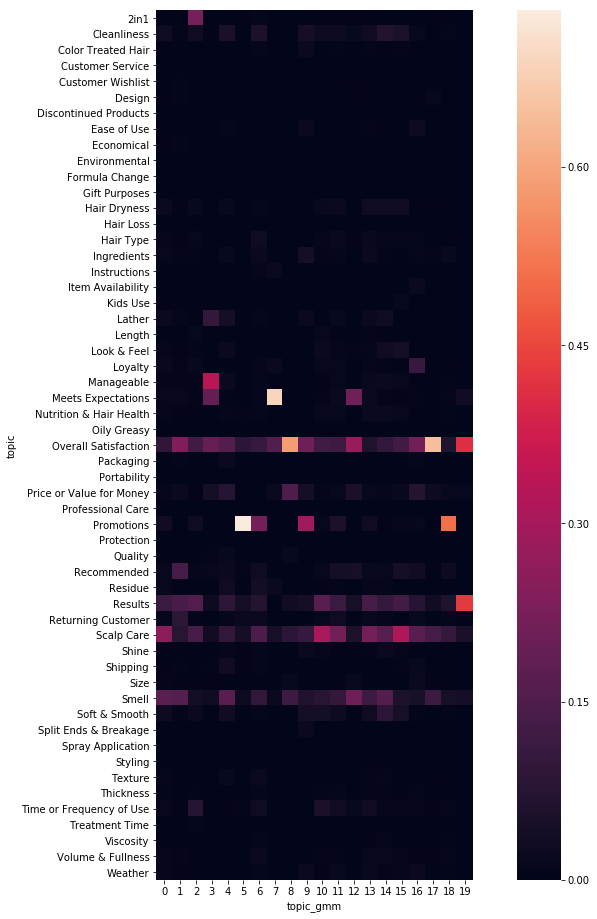

In [27]:
import seaborn as sns

plt.figure(figsize=(16, 16))
sns.heatmap(df_snippet4plotly.pivot("topic", "topic_gmm", "values").fillna(0.), \
            annot=False, square=True)#, vmin=10, vmax=200)#

It seems that a few topics are still loaded with snippets

## What do our topics mean?

In [28]:
df_document_topic_sample = df_document_topic[['dominant_topic']].join(df[['text']]).\
                                loc[df_document_topic.dominant_value>0.98]

In [29]:
from collections import Counter 

In [30]:
exclude = set(string.punctuation)

def preprocess_topic(doc, tags=['NOUN', 'ADJ','VERB','ADV']):
    # remove punctuation
    doc = ''.join(ch for ch in doc if ch not in exclude)
    
    # remove a few words
    doc = doc.replace('shampoo','').replace('hair','').replace('product','')
    
    # lemmatization
    doc = " ".join([token.lemma_ for token in nlp(doc) if ((token.pos_ in tags) and not(token.is_stop))])
    return doc

In [31]:
topWords = []
for i in range(best_ncomp):
    words = ' + '.join([key for key,value in Counter(' '.join(df_document_topic_sample['text'].\
         loc[df_document_topic_sample.dominant_topic==i].\
         apply(preprocess_topic).values.tolist()).split()).most_common(5)])
    topWords.append(words)
    
    print('Topic {:}: {:}'.format(i+1, words))

Topic 1: dandruff + rid + smell + work + good
Topic 2: work + smell + great + job + item
Topic 3: conditioner + head + dandruff + shoulder + use
Topic 4: good + great + price + size + fast
Topic 5: great + good + work + price + smell
Topic 6: purpose + receive + test + review + smell
Topic 7: review + promotion + collect + scalp + dandruff
Topic 8: expect + describe + great + item + advertise
Topic 9: great + excellent + value + stuff + awesome
Topic 10: review + collect + promotion + smell + love
Topic 11: scalp + use + husband + dandruff + head
Topic 12: scalp + smell + dandruff + work + dry
Topic 13: good + smell + like + exactly + great
Topic 14: scalp + dandruff + smell + head + use
Topic 15: smell + great + love + work + good
Topic 16: scalp + great + good + dandruff + work
Topic 17: year + good + price + great + scalp
Topic 18: good + love + dandruff + stop + scalp
Topic 19: opinion + free + scalp + head + smell
Topic 20: work + great + smell + good + dandruff


## What are the main drivers

In [54]:
df_document_drivers = df_document_topic.iloc[:,:-2].apply(lambda x: x>0.2).astype(int)

df_document_drivers.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [55]:
df_document_drivers = df_document_drivers.join(df_orig, how='left')

df_document_drivers.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,rating,product
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,5.0,Head And Shoulders Smooth & Silky Dandruff Sha...
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5.0,Head And Shoulders Green Apple Anti-Dandruff S...
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,4.0,Dove Dermacare Scalp Anti-Dandruff Shampoo Inv...
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5.0,Dove Dermacare Scalp Anti-Dandruff Shampoo Dry...
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4.0,"Head And Shoulders Dry Scalp Care, Almond Oil,..."


In [56]:
# convert to float
def float_(x):
    try:
        y=float(x)
    except:
        y=float('nan')
    return y

df_document_drivers['rating'] = df_document_drivers['rating'].apply(float_)

In [57]:
# put rating in the topic column
for col in df_document_drivers.columns[:-1]:
    df_document_drivers[col] = df_document_drivers[col].astype(float)
    df_document_drivers[col] = df_document_drivers.apply(lambda row: row[col]*row['rating'],axis=1)

In [58]:
# replace 0 with NaN
df_document_drivers.replace(0, np.NaN, inplace=True)

In [37]:
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [60]:
df_document_drivers['brand'] = df_document_drivers['product'].apply(lambda x: 'H&S' if 'head' in x.lower() else 'Dove' if 'dove' in x.lower() else 'other')

In [62]:
df_document_drivers_stats_HS = df_document_drivers.loc[df_document_drivers['brand']=='H&S'].count().reset_index().\
    merge(df_document_drivers.loc[df_document_drivers['brand']=='H&S'].mean().reset_index(),on='index').\
    rename(columns={'0_x':'count','0_y':'impact'}).iloc[:-1,:]
df_document_drivers_stats_HS['brand'] = 'H&S'
df_document_drivers_stats_HS['topWords'] = topWords
df_document_drivers_stats_HS['count'] = df_document_drivers_stats_HS['count']/df_document_drivers_stats_HS['count'].max()

df_document_drivers_stats_DV = df_document_drivers.loc[df_document_drivers['brand']=='Dove'].count().reset_index().\
    merge(df_document_drivers.loc[df_document_drivers['brand']=='Dove'].mean().reset_index(),on='index').\
    rename(columns={'0_x':'count','0_y':'impact'}).iloc[:-1,:]
df_document_drivers_stats_DV['brand'] = 'Dove'
df_document_drivers_stats_DV['topWords'] = topWords
df_document_drivers_stats_DV['count'] = df_document_drivers_stats_DV['count']/df_document_drivers_stats_DV['count'].max()

In [63]:
df_document_drivers_stats_HS.sort_values(by='impact')

,index,count,impact,brand,topWords
1,topic_1,0.018056,3.705882,H&S,work + smell + great + job + item
16,topic_16,0.027616,4.153846,H&S,year + good + price + great + scalp
2,topic_2,0.122677,4.212121,H&S,conditioner + head + dandruff + shoulder + use
18,topic_18,0.303240,4.271454,H&S,opinion + free + scalp + head + smell
13,topic_13,0.682953,4.299378,H&S,scalp + dandruff + smell + head + use
11,topic_11,1.000000,4.338290,H&S,scalp + smell + dandruff + work + dry
10,topic_10,0.050982,4.343750,H&S,scalp + use + husband + dandruff + head
6,topic_6,0.622411,4.353242,H&S,review + promotion + collect + scalp + dandruff
0,topic_0,0.086033,4.370370,H&S,dandruff + rid + smell + work + good
5,topic_5,0.050451,4.421053,H&S,purpose + receive + test + review + smell


In [64]:
df_document_drivers_stats_diff = \
    df_document_drivers_stats_HS[['index','impact','topWords']].merge(df_document_drivers_stats_DV[['index','impact']], on='index')
df_document_drivers_stats_diff['impact'] = df_document_drivers_stats_diff['impact_x']-df_document_drivers_stats_diff['impact_y']
df_document_drivers_stats_diff.sort_values(by='impact', inplace=True)

df_document_drivers_stats_diff

,index,impact_x,topWords,impact_y,impact
1,topic_1,3.705882,work + smell + great + job + item,5.000000,-1.294118
4,topic_4,4.551724,great + good + work + price + smell,5.000000,-0.448276
0,topic_0,4.370370,dandruff + rid + smell + work + good,4.750000,-0.379630
12,topic_12,4.742857,good + smell + like + exactly + great,5.000000,-0.257143
6,topic_6,4.353242,review + promotion + collect + scalp + dandruff,4.469101,-0.115859
7,topic_7,4.950000,expect + describe + great + item + advertise,5.000000,-0.050000
9,topic_9,4.525066,review + collect + promotion + smell + love,4.526718,-0.001652
10,topic_10,4.343750,scalp + use + husband + dandruff + head,4.142857,0.200893
11,topic_11,4.338290,scalp + smell + dandruff + work + dry,3.900000,0.438290
13,topic_13,4.299378,scalp + dandruff + smell + head + use,3.766667,0.532711


In [65]:
df_document_drivers_stats = pd.concat([df_document_drivers_stats_HS, df_document_drivers_stats_DV])

df_document_drivers_stats.head()

,index,count,impact,brand,topWords
0,topic_0,0.086033,4.370370,H&S,dandruff + rid + smell + work + good
1,topic_1,0.018056,3.705882,H&S,work + smell + great + job + item
2,topic_2,0.122677,4.212121,H&S,conditioner + head + dandruff + shoulder + use
3,topic_3,0.020712,4.897436,H&S,good + great + price + size + fast
4,topic_4,0.015401,4.551724,H&S,great + good + work + price + smell


In [66]:
# Create a trace
trace = [
    go.Scatter(
    x    = df_document_drivers_stats['count'].loc[df_document_drivers_stats['brand']=='H&S'],
    y    = df_document_drivers_stats['impact'].loc[df_document_drivers_stats['brand']=='H&S'],
    text = df_document_drivers_stats['topWords'].loc[df_document_drivers_stats['brand']=='H&S'],
    name = 'H&S',
    mode = 'markers+text',
    marker = dict(
        size = 20,
        line = dict(
            width = 2,
            color = 'rgb(22, 96, 167)'),)
),
    go.Scatter(
    x    = df_document_drivers_stats['count'].loc[df_document_drivers_stats['brand']=='Dove'],
    y    = df_document_drivers_stats['impact'].loc[df_document_drivers_stats['brand']=='Dove'],
    text = df_document_drivers_stats['topWords'].loc[df_document_drivers_stats['brand']=='Dove'],
    name = 'Dove',
    mode = 'markers+text',
    marker = dict(
        size = 20,
        line = dict(
            width = 2,
            color = 'rgb(205, 12, 24)'),)
)]    

layout = dict(title = 'Topic Impact',
              xaxis = dict(zeroline = False, title='# of Comments'),
              yaxis = dict(zeroline = False, title='Avg. Rating')
             )

iplot(dict(data=trace, layout=layout))

In [40]:
plot(dict(data=[trace], layout=layout), filename='LM_GMM.html')

'file:///workspace/voc_ratingsreviews/LM_GMM.html'